In [1]:
import numpy as np
import torch
import gpytorch

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import models
import priors

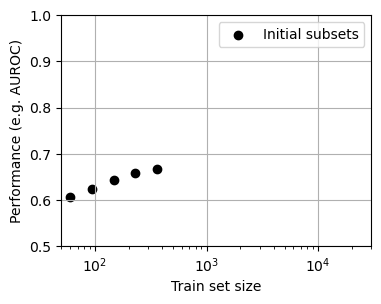

In [3]:
# Define X and Y
X, y = torch.tensor([60, 94, 147, 230, 360]), torch.tensor([0.6067, 0.6240, 0.6429, 0.6574, 0.6664])
# Plot X and y
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(X, y, color='black', alpha=1.0, label='Initial subsets')
ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size')
ax.set_ylabel('Performance (e.g. AUROC)')
ax.legend()
ax.grid()
plt.show()

In [4]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Note: If you want to use the Gaussian process with an arctan mean function use models.GPArctan() instead.
model = models.GPPowerLaw(X, y, likelihood, epsilon_min=0.05, with_priors=True)
likelihood, model, losses = models.train_gp(likelihood, model, X, y, max_iters=50000, lr=0.01)

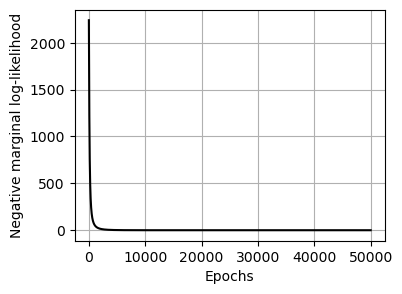

In [5]:
# Check that the model has converged
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.plot(list(range(len(losses))), losses, color='black')
ax.set_xlabel('Epochs')
ax.set_ylabel('Negative marginal log-likelihood')
ax.grid()
plt.show()

In [6]:
# Use predictive posterior to make predictions
linspace = torch.linspace(50, 30000, 29950).long()
with torch.no_grad(): predictions = likelihood(model(linspace))
loc = predictions.mean.numpy()
scale = predictions.stddev.numpy()
# Note: If you want to forecast with 20%-80% change lower and upper percentile.
lower, upper = priors.truncated_normal_uncertainty(0.0, 1.0, loc, scale, lower_percentile=0.025, upper_percentile=0.975) 

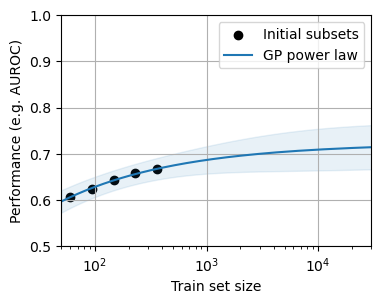

In [7]:
# Plot model
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(X, y, color='black', alpha=1.0, label='Initial subsets')
ax.plot(linspace.detach().numpy(), loc, color='#1f77b4', label='GP power law')
ax.fill_between(linspace.detach().numpy(), lower, upper, color='#1f77b4', alpha=0.1)
ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size')
ax.set_ylabel('Performance (e.g. AUROC)')
ax.legend()
ax.grid()
plt.show()